## Google Colab Arbeitplatz vorbereiten

In [ ]:
!git clone https://github.com/edadunashvili/Monographie.git

In [ ]:
cd /content/Monographie

In [ ]:
!pip install scikit-learn==1.1

In [ ]:
!pip install mglearn

In [ ]:
!pip install --upgrade joblib==1.1.1

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Elguja Dadunashvili: Machine-Learning-Verfahren für die typologisch-vergleichenden Märchenforschung - Teil 1

## Modul für die Aggregation des Korpus von Trainingsdaten 

[Zelle # 1]

1-3: Die Variable 'tupNum', 'repert' und 'ausnahme' gelten für die Auswahl der in dem Trainingsdatenrepositorium angelegte Texte mit dem gesuchten Typ und dem Herkunftsrepertoire. Sowohl die Variable 'typNum' ails auch 'repert' kann mit leeren Anführungszeichen dargestellt werden, für die Variable 'ausnahme' ist entweder ein unwahrscheinlicher Wert (z.B. 'xxyyzz') oder der Wert womit man eine bestimmte Gruppe  von Daten aus der Wahl ausschließen kann eine Pflicht.

4-8: Jedes Mal bei der Aggregation des Korpus von Trainingsdaten wird der gleichnamige alte Korpus gelöscht.


In [2]:
typNum='300'
repert=''
ausnahme='xxyyzz'
def entfernen(var):
    import os
    if os.path.exists(var):
        os.remove(var)
entfernen('episode_binar_train.csv')

In [3]:
def clean(line):
    line = line.replace("\n"," ").strip()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe")
    line = line.replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","")
    line = line.replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a")
    line = line.replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ")
    line = line.replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ")
    line = line.replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','')
    line = line.replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    for i, _ in enumerate(line):
        if (i !=0) and (i!=2):
            line[i]=line[i].lower()
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret
def write_back(words, temp):
    with open(temp, "a", encoding='utf-8') as output:      
        for word in words:
            as_lex = word[0]
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)
def aggreg(temp, ordner):
    import glob
    with open(temp, "w", encoding='utf-8') as output:
        output.write ("quelle,episode,index_string,index_binar\n")
    sorted_files=sorted(glob.glob(ordner))
    pairs = []
    for file in sorted_files:
        if typNum in file and repert in file and not ausnahme in file:
            with open(file, 'r', encoding='utf-8', errors='ignore') as episode:
                for line in episode.readlines():
                    clean_words = clean(line)
                    pairs = pairs + clean_words
    write_back(pairs, temp)
temp = "episode_temp_train.csv"
ordner = "Trainingsdaten/*.txt"
aggreg(temp, ordner)
fin = open('episode_temp_train.csv','r', encoding ='utf-8')
fout = open('episode_string_train.csv', "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"")
               .replace("', '", "','").replace(" '", "'"))
fin.close()
fout.close()
fin = open('episode_string_train.csv','r', encoding='utf-8') 
fout = open('episode_binar_train.csv', "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))             
fin.close()
fout.close()
entfernen('episode_temp_train.csv')
entfernen('episode_string_train.csv')

[Zelle # 2]

1-59: Aggregation der Datei 'episode_temp_train.csv' (eine Funktion). Die im Ordner „Trainingsdaten“ angelegte TXT Dateien werden in der CSV Datei aggregiert und in das root Repositorium verlegt. 

60-66: Umwandlung 'episode_temp_train.csv' in die Datei 'episode_string_train.csv'.

67-72: 'episode_string_train.csv' laden, von den überflüssigen Zeichen bereinigen und ins Trainingsdatenkorpus 'episode_binar_train.csv' umwandeln.

ab-73: Unnotige Aggregationen werden gelöscht.

##  Herstellung des Modells und der prototypischen Metaepisode 

[Zelle # 3]

1-5: Trainingdatenkorpus zugreiffen und der im Datenfeld 'index_string' eingetragene Merkmalen mitsamt der Vorkommenshäufigkeitsrate einbelden.

In [4]:
import pandas as pd
from collections import Counter
df = pd.read_csv('episode_binar_train.csv',  encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({'e300_e_vorfeld_des_kampfes_bis_zum_sieg': 41, 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not': 36, 'e300_o_auftritt_des_HD_vor_dem_AG_bis_zur_erkennung_seiner_heldentat': 34, 'e300_g_nach_dem_sieg_bis_zur_trennung_des_HD_und_des_OB': 29, 'e300_k_misshandlung_des_FH_bis_zur_hochzeit': 27, 'e300_m_rueckkehr_des_HD_und_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit': 18, 'e303_c_eingangssituation_bis_zur_trennung': 18, 'eUNDF_a_': 16, 'e303_g_erstes_treffen_mit_dem_AN': 16, 'e303_i_von_der_erkundigung_der_not_bis_zum_aufbruch_des_HF_zum_AN': 15, 'e303_k_vom_aufbruch_zum_AN_bis_zum_sieg_ueber_ihn': 15, 'e554_e_leistung_des_HD_gegenueber_dem_tier_und_aussprechen_der_dankbarkeit': 12, 'e315_a_': 12, 'eCoM_c_conceptia_magica': 11, 'e300_l_wiederbelebung_des_HD': 9, 'e300_i_rueckkehr_des_OB_und_die_suche_nach_dem_HD': 7, 'e300_q_von_der_begegnung_mit_dem_vogel_bis_zum_ende_des_fluges': 7, 'e550_a_': 7, 'e303_m_eifersucht': 5, 'e328_a_': 4, 'e303_q_ruec

[Zelle # 4]

1: In den obeneingeblendete Merkmalen eine Episode Kopieren und hier als Wert der Variable 'gesep' einfügen. 

In [5]:
gesep = 'e300_m_rueckkehr_des_HD_und_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit'

[Zelle # 5]

1-6: In Trainingsdaten die gesuchte Episode ('gesep') mit Einsen (1), den Rest mit Nullen (0) etikettieren und die Änderung speichern.

In [6]:
for i, gesuchte_episode in enumerate(df.index_string):
    if (gesuchte_episode == gesep):
        df.index_binar[i]='1'
    else: 
            df.index_binar[i]='0'
df.to_csv('episode_binar_train.csv', encoding='utf-8', index=False)

[Zelle # 6]

1-4: Im Trainingsdatenkorpus die Datenfelder für Probetexte (X_train) und für die Merkmalen (y_train) bestimmen und die Bilanz zwischen negativ (0) und positiv (1) etikettierten Datensätzen betrachten ( s. Counter).

In [7]:
X_train=(df['episode'])
y_train=(df['index_binar'])
indexliste=Counter(df.index_binar)
print(indexliste, sep='\n')

Counter({'0': 367, '1': 18})


[Zelle # 7]

1: Die in die eckige Klammern eingetragene Wörter werden zusätzlich in die vorhandene Stopwörter-Liste eingefügt. Einzelnes Wort muss dabei mit Anführungszeichen umgeschlossen und von andren Wörter durch das Komma getrennt werden, ein Beispiel: ['mein','dein']. 

2-6: Datenfeld 'episode' von konwentionelen und von uns eingegebenen Stoppwörter bereinigen. 

In [8]:
custom_stop_word_list=[]
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
NLTK_stop_words_list=stopwords.words('german')
de = custom_stop_word_list + NLTK_stop_words_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elguj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[Zelle # 8]

1-8: Einrichtung einer sciki-learn Pipeline mit Klassen LogisticRegression, TfidVectorizer und GridSearchCV. 

9-10: Modell auswerten (s. Bester Score aus der Kreuzvalidierung:).

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=3, stop_words=de, ngram_range=(1,1), norm=None), 
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}     
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Bester Score aus der Kreuzvalidierung: {:.2f}".format(grid.best_score_))

Bester Score aus der Kreuzvalidierung: 0.97


[Zelle # 9]

1-6: Aus dem Modell die Liste der positiven und negativen Merkmalen extrachieren, Zahl der Merkmalen einblenden (s. Gesamte Anzahl der Wörter:).

In [10]:
import numpy as np
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
max_value = vectorizer.transform(X_train).max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print("Gesamte Anzahl der Wörter: {}".format(len(vectorizer.vocabulary_)))

Gesamte Anzahl der Wörter: 2365


[Zelle # 10]

1-7: Merkmalen mit höchsten Koeffizienten visualisieren (blau=positiv, rot=negativ). Variable 's_zahl' stellt fest wieviel Merkmalen von beiden Kategorien eingeblendet werden muss. 

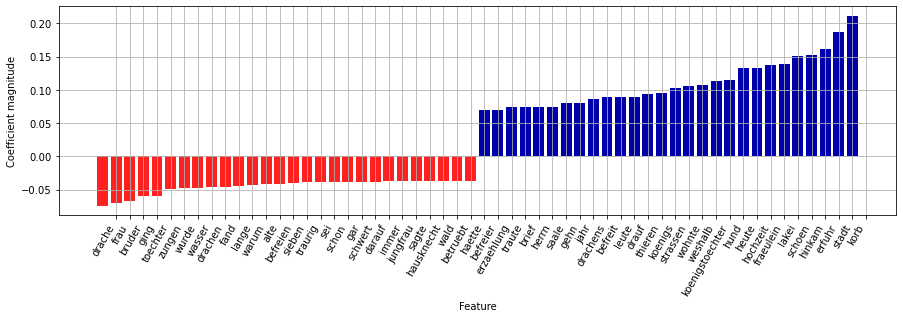

In [12]:
s_zahl = 28
import matplotlib.pyplot as plt
import mglearn
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names,  n_top_features=s_zahl)
plt.grid()
plt.savefig(gesep+'.jpg', dpi=80)

[Zelle # 11]

1-5: Anpassung zwischen minimaler und maximaler Koeffizienten für die Merkmalen. Je nach der Episode kann die Kurve der expotentielle Abnahme unterschiedlich sein, dementsprechend entscheidet man für größere oder kleinere Zahl der relevante Merkmale. Diese wird durch die Variable 'n_zahl' einegstellt (Zeile 1).

6-7: Visualisierung der ausgewählten Merkmalen. 

In [586]:
n_zahl = 25
gio=(grid.best_estimator_.named_steps["logisticregression"].coef_[0])
n_top=np.argsort(gio)
text_pos=feature_names[n_top[-n_zahl:]]
text_neg=feature_names[n_top[0:n_zahl]]
print("Positive Merkmale:\n{}".format(text_pos))
print ("Negative Merkmale:\n{}".format(text_neg))

Positive Merkmale:
['brief' 'herrn' 'saale' 'gehn' 'jahr' 'drachens' 'befreit' 'leute'
 'drauf' 'thieren' 'koenigs' 'strassen' 'wohnte' 'weshalb'
 'koenigstoechter' 'hund' 'heute' 'hochzeit' 'fraeulein' 'lakei' 'schoen'
 'hinkam' 'erfuhr' 'stadt' 'korb']
Negative Merkmale:
['drache' 'frau' 'bruder' 'ging' 'toechter' 'zungen' 'wurde' 'wasser'
 'drachen' 'fand' 'lange' 'warum' 'alte' 'befreien' 'sieben' 'traurig'
 'sei' 'schon' 'gar' 'schwert' 'darauf' 'immer' 'jungfrau' 'sagte'
 'hausknecht']


[Zelle # 12]

1-17: Bestimmte Merkmale in die neue txt Datei speichern(1-7) gesamte Information durch die Datenfelder strukturieren (8-12) und  nach dem Löschen der alten Datei (13) in Messdatenordner anlegen (14-17).

In [587]:
import csv 
import shutil, os
filename = '0_'+gesep
tit=(text_pos)
with open (filename+'.txt', 'wt', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerow(tit)
with open(filename+'.txt', 'r') as file:
    file_contents = file.read().replace("\n", "")
    frt_contents = filename+'|'+file_contents+'|0|0'
with open(filename+'.txt', 'wt', encoding='utf-8') as f:
        f.write(frt_contents)
entfernen('Messdaten/'+filename+'.txt')
import glob
files = glob.glob(filename+'.txt')
for f in files:
    shutil.move(f, 'Messdaten/')

##  Herstellung des Messdatenkorpus 

[Zelle # 13]

1-3: Die Variable 'tupNum', 'repert' und 'ausnahme' gelten für die Auswahl der in dem Messdatenrepositorium angelegte Texte mit dem konkretem Typ und dem Herkunftsrepertoire. Sowohl die Variable 'typNum' ails auch 'repert' kann mit leeren Anführungszeichen dargestellt werden. Für die Variable 'ausnahme' ist entweder ein unwahrscheinlicher Wert (z.B. 'xxyyzz') oder der Wert womit man eine bestimmte Gruppe von Daten aus der Wahl ausschließen kann eine Pflicht.

4: Der vorhandene Messdaten-Korpus löschen (falls vorhanden)

5-7: In dem Messdatenordner Messdaten parsen und einen 'episode_temp_mess.csv' Korpus aggregieren.

8-16: 'episode_temp_mess.csv' von den überflussigen Zeichen bereinigen und ins  Messdatenkorpus - 'episode_binar_mess.csv' umwandeln.

17-21: Datenfelder deklarieren und Datensätzen zählen (s. Counter), anschließend unnotige Temp-Aggregation löschen.

22-29: Messdatenkopus aus den Epsoden bestimmen und alle andere Datenfelder ignorieren

In [588]:
typNum=''
repert=''
ausnahme='xxyyzz'
entfernen('episode_binar_mess.csv')
temp = "episode_temp_mess.csv"
ordner = "Messdaten/*.txt"
aggreg(temp, ordner)
from collections import Counter
fin = open("episode_temp_mess.csv",'r', encoding ='utf-8')
fout = open('episode_binar_mess.csv', "wt", encoding ='utf-8')
for efz in fin:
    fout.write(efz.replace(', "["',"").replace('"[', "")
               .replace(']"',"").replace("', '", "','")
               .replace(" '", "'").replace("'",""))   
fin.close()
fout.close()
df = pd.read_csv('episode_binar_mess.csv', encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_binar)
print(indexliste)
entfernen('episode_temp_mess.csv')
t_corpus = []
file = 'episode_binar_mess.csv'
with open(file, "r", encoding='utf-8') as maerchen:
    maerchen = df.episode
    reader = csv.reader(maerchen, delimiter = "|") 
    for row in reader:       
        lst = str(row)
        t_corpus.append(lst)

Counter({0: 105})


## Vorhersage durch LOGISTICREGRESSION

[Zelle # 14]

1-2: Vorhersage treffen.

3: Der synthetische Datensätzen wird ausgeschloßen. 

4: Jeder positiv bewerteter Datensatz wird extra eingebledet.

In [589]:
mod_pred=grid.predict(t_corpus)
for index in enumerate(mod_pred): 
    if '1' in (index) and index[0]>0:   
        print ('Positiv bewerteter Datensatz:{}'.format(index))

[Zelle # 15]

1-7: Alle probabilitische Vorhersagen abruffen. Durch das Manipulieren der Variable 'pos>=' in der Zeile 6 wird der minimale Score angepasst.

In [590]:
all_pred=grid.predict_proba(t_corpus) 
sort_index=np.flip(all_pred[:,1].argsort())
for num_pos in sort_index:
    pos=all_pred[num_pos][1]
    for i,t_corpus_element in enumerate(t_corpus):
        if i==num_pos  and num_pos>0 and pos>=0.005:
            print(num_pos,'-', pos,'-', df.quelle[num_pos],'-', df.episode[num_pos],'\n')

65 - 0.02830579203229902 - mess_23 - nachdem er auf diese weise den weg gereinigt hatte ging er in eine kate er sagte zu dem kaetner auf welche weise koennte ich wohl jetzt aus dem hochzeitshaus das beste essen bekommen das sie dort haben  rede doch nicht solches zeug meinte der alte kaetner sorg nur dass du sonst in frieden bleiben kannst doch der soldat steckte dem kleinen hund ein taschentuch ins maul und dieser lief zu der braut und legte sich ihr schmeichelnd zu fuessen die braut erkannte den hund sogleich weil er um den hals eine goldkette trug die sie ihm angelegt hatte sie band in das taschentuch das beste was auf dem tische war als der hund in die kate zurueckkam setzten sich der soldat und der alte kaetner zum essen und der soldat schickte den kleinen hund wieder fort um einen krug voll getraenke zu holen auch das bekam er aber da merkte der braeutigam die geschichte weil er den hund kannte und er schickte soldaten aus seinen gegner zu toeten eine ganze kompanie wurde ihm ent

##  Vorhersage durch die COSINE-SIMILARITY

[Zelle # 16]

1-14: Daten im Messdatenkorpus Vektorisieren, Transformieren und die Metrik für die Vorhersagefunktion definieren.

In [591]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer
vectorizers = vectorizer(analyzer='word', ngram_range=(1,1),
                         min_df = 2, stop_words = de)
vokabular =  vectorizers.fit_transform (t_corpus)
metrik = cosine_similarity
def find_similar(vokabular, index, top_n =-1):   
    metriks = metrik(vokabular[index:index+1], vokabular).flatten()
    related_docs_indices = [i for i in metriks.argsort()[::-1] 
                            if i != index]
    return [(index, metriks[index]) for index 
            in related_docs_indices][0:top_n]

[Zelle # 17]

1-3: Gesuchte Episode (Zielepisode) einblenden. Die gesuchte Episode wird wird die 'n_te'-Variable bestimmt. Manuell eingepflegte Zielepisoden sollen deshalb immer in der ersten Reihen der Korpusdatensätzen stehen. Wir empfehlen deshalb, dass diese Daten mit dem Prefix '0_' benannt wird.)

4: Synthetische Datei aus dem Messdatenordner entfernen.

In [592]:
n_te = 0
synt = t_corpus[n_te]
print(df.quelle[n_te],'-', synt)
entfernen('Messdaten/'+'0_'+gesep+'.txt')

0_e300_m_rueckkehr_des_HD_und_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit - ['brief herrn saale gehn jahr drachens befreit leute drauf thieren koenigs strassen wohnte weshalb koenigstoechter hund heute hochzeit fraeulein lakei schoen hinkam erfuhr stadt korb']


[Zelle # 18]

1-3: Suchen starten und die Ergebnisse einblenden.

In [593]:
for index, score in (find_similar(vokabular, n_te)):
    if (df.index_string[index]==0 and score>0.05):
        print(index,'-', score,'-', df.quelle[index],'-', 
           t_corpus[index], '-',  df.index_binar[index],'-', df.index_binar[index],'\n' )

28 - 0.18341433272334132 - mess_47 - ['dieser aber war in die stadt getreten wo er alles in bestuerzung und trauer fand alle fenster waren mit schwarzen tuechern verhangen er erkundigte sich daher was die ursache solcher trauer waere und erfuhr dass riesen in der naehe wohnten welche die stadt immer in angst und schrecken hielten und dass sieben drachen in einer nahen hoehle hausten welchen sie jeden tag einen menschen opfern muessten  und endlich sey eine schlange nicht weit auf einem baume welche alle menschen verzehre die ungluecklicher weise in ihr bereich kaemen niemand aber waere zu finden welcher die stadt von diesen ungeheuern befreyen wollte'] - 0 - 0 

66 - 0.1572595136781638 - mess_23 - ['darauf schrieb er an den koenig einen brief dass er in die kate kommen moege und liess den brief durch den hund hinbringen da wollte die koenigstochter auch mitgehen aber der koenig sagte was willst du denn dort es wird gewiss auch mein ende sein aber das maedchen sprang hinten auf den wage

## Ende 